# Natural Language Processing with Disaster Tweets

## Описание

В этом конкурсе требуется создать модель машинного обучения, которая предсказывает, какие твиты посвящены реальным катастрофам, а какие нет.

## Загрузка данных

In [1]:
!pip install pathlib==1.0.1 -q

In [2]:
import os
import torch
import pickle
import random 
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from datasets import Dataset, load_metric

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
    gc.collect()
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [28]:
# объявляем переменную для хранения данных
DIR='./data'
CACHE='./data/cache'
RANDOM_STATE=12345

In [5]:
df = pd.read_csv(f'{DIR}/train.csv', index_col='id')

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


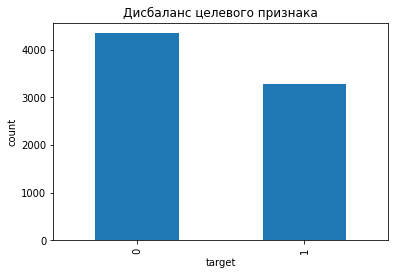

In [6]:
#проверим на дисбаланс целевого признака
df['target'].value_counts().plot(kind='bar')
plt.title('Дисбаланс целевого признака')
plt.ylabel('count')
plt.xlabel('target')
plt.show()

__Примечание__: существенного дисбаланса не видно

## Заполнение пропусков

### Location

In [7]:
# Проверяем уникальность
df['location'].nunique()

3341

In [8]:
df['location'].isna().sum()

2533

Заполнять попуски будем при помощи дополнительной модели, которая будет предсказывать наличия страны (города) в `location`

In [9]:
from transformers import AutoModelForTokenClassification, AutoTokenizer
from transformers import pipeline

In [10]:
# заранее отбёрём только те, у которых location заполнен
dfl = df.loc[~df['location'].isna()]

In [11]:
# data file location
DFL_NAME = CACHE + '/dfl.csv'

if os.path.exists(DFL_NAME):
    dfl = pd.read_csv(DFL_NAME)
else:
    MODEL_PATH = "ml6team/bert-base-uncased-city-country-ner"
    model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

    # The model predicts 3 different tags: OTHER, CITY and COUNTRY
    nlp = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple", device=device)

    def is_country(txt):
        pred = nlp(txt)
        pbar.update(1)

        if len(pred) > 0:
            return 1 if pred[0]['entity_group'] != 'OTHER' else 0

        return 0

    # новый целевой признак, содержится ли в подстроке location упоминание о городе
    with tqdm(total=dfl.shape[0]) as pbar:
        dfl['isCountry'] = dfl['location'].apply(is_country)

    dfl.to_csv(CACHE + '/dfl.csv')

Обучим модель для определения принадлежности твита к "стране" или "городу"

In [12]:
dfl['isCountry'].value_counts()

1    3835
0    1245
Name: isCountry, dtype: int64

Заметен дисбаланс "классов"

In [13]:
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import TensorDataset
from datasets import Dataset, load_metric

In [14]:
id2label = {
    0: "OTHER",
    1: "COUNTRY"
}
label2id = {
    "OTHER": 0,
    "COUNTRY": 1
}

In [15]:
MODEL_PATH = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_PATH, 
        num_labels=2,
        label2id=label2id,
        id2label=id2label)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

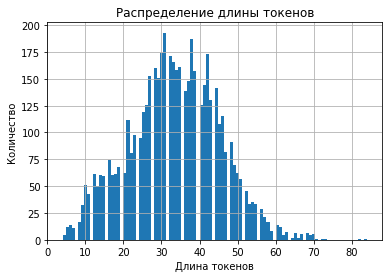

In [16]:
# Поиск максимальной длины твита
seq_len = [len(tokenizer.encode(i, add_special_tokens=True)) for i in dfl['text']]

pd.Series(seq_len).hist(bins = 100)
plt.title('Распределение длины токенов')
plt.xlabel('Длина токенов')

plt.ylabel('Количество')
plt.show()

In [17]:
# округлим до степени 2 (16, 32, 64)
max_seq_len = 32

In [18]:
# специально переименовывем колонку целевого признака
dfl = dfl.rename(columns={'target': 'label'})

In [19]:
# создаём dataset
# для тестирования выделяем 10%
raw_datasets = Dataset.from_pandas(dfl, preserve_index=False).train_test_split(test_size=0.1)

In [20]:
def tokenize_function(examples):
    return tokenizer(examples["text"],
                     padding="max_length",
                     max_length=max_seq_len,
                     truncation=True,
                     return_attention_mask=True,
                     return_token_type_ids=True,
                     return_tensors='pt')


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["test"]

Map:   0%|          | 0/4572 [00:00<?, ? examples/s]

Map:   0%|          | 0/508 [00:00<?, ? examples/s]

In [21]:
train_dataset

Dataset({
    features: ['id', 'keyword', 'location', 'text', 'label', 'isCountry', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 4572
})

In [22]:
class_wts = compute_class_weight(class_weight='balanced',
                                 classes=np.unique(dfl['label']),
                                 y=dfl['label'])

class_wts

array([0.88072122, 1.15664845])

In [23]:
weights= torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

Создаём собственный тренажёр для обновления функции потерь

In [24]:
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        """
        Переопределяем для учёта баланса классов
        """
        outputs = model(**inputs)
        logits = outputs.get('logits')

        labels = inputs.get('labels')

        loss_func = nn.CrossEntropyLoss(weight=weights)

        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss

Определяем метрику F1

In [25]:
metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return { "f1": metric.compute(predictions=predictions, references=labels) }

C:\Users\a-krasnov\AppData\Local\Temp\ipykernel_13832\3470913139.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("f1")


In [29]:
# создаём бач рекомедованного размера (можно быть либо 32, либо 16)
batch_size = 32
# количество эпох для обучения
train_epochs = 3

In [30]:
logging_steps = len(train_dataset) // batch_size

training_args = TrainingArguments("test_trainer_keyword",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=train_epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  logging_steps=logging_steps)

trainer = WeightedLossTrainer(model=model,
                              args=training_args,
                              train_dataset=train_dataset,
                              eval_dataset=eval_dataset,
                              compute_metrics=compute_metrics,
                              tokenizer=tokenizer)

In [32]:
MODEL_LOCATION_PATH = CACHE + '/bert-base-uncased-location/model'

In [33]:
# фиксируем state
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

if not os.path.exists(MODEL_LOCATION_PATH):
    trainer.train()
    trainer.save_model(MODEL_LOCATION_PATH)
    trainer_eval = trainer.evaluate()
    print(f'Результат метрики F1 равно', round(trainer_eval['eval_f1']['f1'], 3))

In [34]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_LOCATION_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_LOCATION_PATH, num_labels=2)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [35]:
dfl = df[df['location'].isna()]

dfl.shape[0]

2533

In [36]:
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)
nlp('Forest fire near La Ronge Sask. Canada')

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[{'label': 'COUNTRY', 'score': 0.9993045330047607}]

In [39]:
def is_country(txt):
    pred = nlp(txt)
    pbar.update(1)

    if len(pred) > 0:
        return 1 if pred[0]['label'] != 'OTHER' else 0

    return 0

# новый целевой признак, содержится ли в подстроке location упоминание о городе
with tqdm(total=dfl.shape[0]) as pbar:
    dfl['isCountry'] = dfl['text'].apply(is_country)

100%|██████████████████████████████████████████████████████████████████████████████| 2533/2533 [02:43<00:00, 12.40it/s]C:\Users\a-krasnov\AppData\Local\Temp\ipykernel_13832\3613308982.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfl['isCountry'] = dfl['text'].apply(is_country)
100%|██████████████████████████████████████████████████████████████████████████████| 2533/2533 [02:45<00:00, 15.35it/s]


In [51]:
dfl.loc[dfl['isCountry'] == False].sample(5)

,keyword,location,text,target,isCountry
id,,,,,
8855,smoke,NaN,I want to smoke ??,0,0
4402,electrocute,NaN,Kids got Disney version of the game Operation ...,0,0
2538,collision,NaN,my favorite lady came to our volunteer meeting...,1,0
6648,inundation,NaN,Sprinklers: FAQ About Lawn Inundation Systems ...,0,0
3696,destroy,NaN,@engineermataRAI ate mataas kc rating..but the...,0,0


In [48]:
if not os.path.exists(CACHE + '/df_normal_location.csv'):
    # создадим новый признак в основной DataFrame
    with tqdm(total=df.shape[0]) as pbar:
        df['isCountry'] = df['text'].apply(is_country)
        
    df.to_csv(CACHE + '/df_normal_location.csv')

df = pd.read_csv(CACHE + '/df_normal_location.csv')
df['isCountry'].value_counts()

0    4289
1    3324
Name: isCountry, dtype: int64

### Keyword

Аналогично `location` выполним обработку поля `keyword`

In [166]:
df['keyword'].nunique()

221

In [167]:
df['keyword'].isna().sum()

61

In [168]:
# после просмотра значений, заменим специальный символ на пробел
df['keyword'] = df['keyword'].str.replace('%20', ' ')

In [169]:
# заранее отбёрём только те, у которых location заполнен
dfk = df.loc[~df['keyword'].isna()]

In [170]:
dfk['keyword'].value_counts()

fatalities             45
deluge                 42
armageddon             42
sinking                41
damage                 41
                       ..
forest fire            19
epicentre              12
threat                 11
inundation             10
radiation emergency     9
Name: keyword, Length: 221, dtype: int64

In [171]:
keywords = list(dfk['keyword'].unique())

for idx in range(len(keywords)):
    id2label[idx] = keywords[idx].upper()
    label2id[keywords[idx].upper()] = idx

In [172]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_PATH, 
        num_labels=len(keywords),
        label2id=label2id,
        id2label=id2label)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [173]:
# округлим до степени 2 (16, 32, 64)
max_seq_len = 32

In [174]:
dfk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7552 entries, 31 to 7582
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         7552 non-null   int64 
 1   keyword    7552 non-null   object
 2   location   5080 non-null   object
 3   text       7552 non-null   object
 4   target     7552 non-null   int64 
 5   isCountry  7552 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 413.0+ KB


In [175]:
from sklearn.preprocessing import LabelEncoder

In [176]:
encoder = LabelEncoder()
data_ordinal = encoder.fit_transform(dfk['keyword'])

dfk['keyword'] = data_ordinal

C:\Users\a-krasnov\AppData\Local\Temp\ipykernel_13832\4018264777.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfk['keyword'] = data_ordinal


In [177]:
# специально переименовывем колонку целевого признака
dfk = dfk.rename(columns={'keyword': 'label'})

In [178]:
# создаём dataset
# для тестирования выделяем 10%
raw_datasets = Dataset.from_pandas(dfk, preserve_index=False).train_test_split(test_size=0.1)

def tokenize_function(examples):
    return tokenizer(examples["text"],
                     padding="max_length",
                     max_length=max_seq_len,
                     truncation=True,
                     return_attention_mask=True,
                     return_token_type_ids=True,
                     return_tensors='pt')


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["test"]

Map:   0%|          | 0/6796 [00:00<?, ? examples/s]

Map:   0%|          | 0/756 [00:00<?, ? examples/s]

In [179]:
class_wts = compute_class_weight(class_weight='balanced',
                                 classes=np.unique(dfk['label']),
                                 y=dfk['label'])

weights= torch.tensor(class_wts, dtype=torch.float)
weights = weights.to(device)

In [185]:
metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return { "f1": metric.compute(predictions=predictions, references=labels, average="weighted") }

In [190]:
# создаём бач рекомедованного размера (можно быть либо 32, либо 16)
batch_size = 32
# количество эпох для обучения
train_epochs = 10

In [191]:
logging_steps = len(train_dataset) // batch_size

training_args = TrainingArguments("test_trainer_keyword",
                                  evaluation_strategy="epoch",
                                  num_train_epochs=train_epochs,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  logging_steps=logging_steps)

trainer = WeightedLossTrainer(model=model,
                              args=training_args,
                              train_dataset=train_dataset,
                              eval_dataset=eval_dataset,
                              compute_metrics=compute_metrics,
                              tokenizer=tokenizer)

In [192]:
MODEL_KEYWORD_PATH = CACHE + '/bert-base-uncased-keyword/model'

In [193]:
# фиксируем state
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)

if not os.path.exists(MODEL_KEYWORD_PATH):
    trainer.train()
    trainer.save_model(MODEL_KEYWORD_PATH)
    trainer_eval = trainer.evaluate()
    print(f'Результат метрики F1 равно', round(trainer_eval['eval_f1']['f1'], 3))

C:\Users\a-krasnov\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1
1,3.812500,3.458012,{'f1': 0.647503947734303}
2,3.101000,2.855781,{'f1': 0.7532274750528719}
3,2.550100,2.372598,{'f1': 0.8122282567295355}
4,2.082800,2.005795,{'f1': 0.8346487066725162}
5,1.705100,1.737196,{'f1': 0.8432894161904186}
6,1.422300,1.527225,{'f1': 0.8499111160660869}
7,1.217500,1.389491,{'f1': 0.8508518346655356}
8,1.071500,1.301445,{'f1': 0.8544717450314778}
9,0.980200,1.246208,{'f1': 0.8542536136625527}
10,0.931000,1.234886,{'f1': 0.854659600973302}


Результат метрики F1 равно 0.855


In [194]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_KEYWORD_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_KEYWORD_PATH, num_labels=len(keywords))
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [195]:
nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)
nlp('Forest fire near La Ronge Sask. Canada')

[{'label': 'FOREST FIRE', 'score': 0.24594949185848236}]

In [205]:
# создадим вектор признаков
df = pd.get_dummies(df, columns=['keyword'], drop_first=True)

## Text to vector

Преобразуем значение поля `text` в вектор и для этого используем `transformers`

In [206]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [207]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')

In [208]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

def text2vector(sentences):
    #Tokenize sentences
    encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=128, return_tensors='pt').to(device)

    #Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

    #Perform pooling. In this case, mean pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    pbar.update(1)
    ar = sentence_embeddings[0].to('cpu').detach().numpy()
    return ar

In [209]:
# если в во временной папки нет векторов, то создадим его
if os.path.exists(DIR + '/text_vectors.pickle'):
    text_vectors = pickle.load(open(DIR + '/text_vectors.pickle', 'rb'))
    df['text_vector'] = text_vectors
else:
    with tqdm(total=df.shape[0]) as pbar:
        df['text_vector'] = df['text'].apply(lambda x: text2vector(x))

    pickle.dump(df['text_vector'], file = open(DIR + '/text_vectors.pickle', 'wb'))

## Location & Keyword to vector

Объеденим вектор `location` и `keyword`

In [210]:
# создание вектора
df['feature_vector'] = df.drop(columns=['text_vector', 
                                        'text', 
                                        'location', 
                                        'target', 
                                        'location_word_count']) \
                        .apply(lambda x: x.values, axis=1)

Объеденим два вектора `feature_vector` и `text_vector`

In [211]:
def join_vectors(row):
    """
    Объединяем два вектора

    Параметры:
    ----------
    row: Serias

    Результаты:
    numpy.ndarray - объдинённый вектор
    """

    return np.concatenate((row['feature_vector'], row['text_vector']))

df['finish_vector'] = df.apply(join_vectors, axis=1)

In [212]:
print(f'Длина итогового вектора равна {df.iloc[0]["feature_vector"].shape[0]} + {df.iloc[0]["text_vector"].shape[0]} = {len(df.iloc[0]["finish_vector"])}')

Длина итогового вектора равна 225 + 768 = 993


## Обучение

In [213]:
# определим дополнительные переменные
RANDOM_STATE=12345
N_JOBS = 4
CV = 5

In [214]:
# вектор
features = df['finish_vector']
# целевой признак
target = df['target']

In [215]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE, shuffle=True, stratify=target)

#features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size=0.25, random_state=RANDOM_STATE, shuffle=True, stratify=target_train)

print(f'Обучающая выборка:', features_train.shape[0])
#print(f'Тестовая выборка:', features_test.shape[0])
print(f'Валидационная выборка:', features_valid.shape[0])

Обучающая выборка: 5709
Валидационная выборка: 1904


Так как все признаки у нас являются числовыми, приведём их к одному распределению (нормализуем)

In [216]:
len(features_train.iloc[0])

993

In [217]:
scaler = StandardScaler()

features_train = scaler.fit_transform(features_train.tolist())
features_valid = scaler.transform(features_valid.tolist())
#features_test = scaler.transform(features_test.tolist())

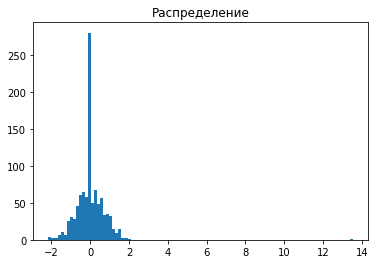

In [218]:
plt.hist(features_train[0], bins=100)

plt.title('Распределение')
plt.show()

Обучим несколько моделей:
* LogisticRegression - baseline
* RandomForestClassifier
* CatBoost
* Нейронная сеть

In [219]:
scores = []

In [220]:
def score_info(model_name, score):
    """
    Вспомогательная функция для вывода качества метрики
    
    Параметры:
    ----------
    model_name: string - имя модели
    score: float - показатель метрики
    """
    scores.append([model_name, score])
    
    print()
    print(f'Качество метрики F1 для {model_name} = {round(abs(score), 3)}')

### LogisticRegression - baseline

In [221]:
%%time

lr_model = None
lr_gs = None

# используем кэш
if os.path.exists(DIR + '/lr_gs.pickle'):
    lr_gs = pickle.load(open(DIR + '/lr_gs.pickle', 'rb'))
    
    lr_model = lr_gs.best_estimator_
else:
    
    params = {
        'penalty': ['l2'],
        'max_iter': [100, 200, 300]
    }

    lr_gs = GridSearchCV(estimator=LogisticRegression(random_state=RANDOM_STATE, n_jobs=N_JOBS), param_grid=params, cv=CV, scoring='f1', verbose=3)
    lr_gs.fit(features_train, target_train)
    lr_model = lr_gs.best_estimator_
    
    pickle.dump(lr_gs, file = open(DIR + '/lr_gs.pickle', 'wb'))

print(lr_gs.best_params_)

score_info('LogisticRegression', lr_gs.best_score_)

{'max_iter': 200, 'penalty': 'l2'}

Качество метрики F1 для LogisticRegression = 0.747
CPU times: total: 0 ns
Wall time: 1 ms


### RandomForestClassifier

In [222]:
%%time

rf_model = None
rf_gs = None

# используем кэш
if os.path.exists(DIR + '/rf_gs.pickle'):
    rf_gs = pickle.load(open(DIR + '/rf_gs.pickle', 'rb'))
    
    rf_model = rf_gs.best_estimator_
else:
    params = {
        "n_estimators": range(1, 41, 5),
        "max_depth": range(1, 41, 5)
    }
    rf_gs = GridSearchCV(estimator=RandomForestClassifier (random_state=RANDOM_STATE, n_jobs=N_JOBS), param_grid=params, cv=CV, scoring='f1', verbose=3)
    rf_gs.fit(features_train, target_train)
    rf_model = rf_gs.best_estimator_
    
    pickle.dump(rf_gs, file = open(DIR + '/rf_gs.pickle', 'wb'))

print(rf_gs.best_params_)
score_info('RandomForestClassifier', rf_gs.best_score_)

{'max_depth': 26, 'n_estimators': 36}

Качество метрики F1 для RandomForestClassifier = 0.735
CPU times: total: 15.6 ms
Wall time: 6 ms


### CatBoostClassifier

In [223]:
%%time

cb_model = None
cb_gs = None

# используем кэш
if os.path.exists(DIR + '/cb_gs.pickle'):
    cb_gs = pickle.load(open(DIR + '/cb_gs.pickle', 'rb'))
    
    cb_model = cb_gs.best_estimator_
else:
    params = {
        'iterations': [300, 600, 1000],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8]
    }

    cb_gs = GridSearchCV(estimator=CatBoostClassifier(random_state=RANDOM_STATE, loss_function="Logloss", eval_metric='F1', logging_level='Silent'), param_grid=params, cv=CV, scoring='f1', verbose=3)
    cb_gs.fit(features_train, target_train)
    cb_model = cb_gs.best_estimator_
    
    pickle.dump(cb_gs, file = open(DIR + '/cb_gs.pickle', 'wb'))

print(cb_gs.best_params_)
score_info('CatBoostClassifier', cb_gs.best_score_)

{'depth': 8, 'iterations': 1000, 'learning_rate': 0.1}

Качество метрики F1 для CatBoostClassifier = 0.77
CPU times: total: 31.2 ms
Wall time: 7 ms


### Нейронная сеть

In [224]:
features_train, features_test, target_train, target_test = train_test_split(features_train, target_train, test_size=0.25, random_state=RANDOM_STATE, shuffle=True, stratify=target_train)

In [225]:
features_train = torch.FloatTensor(features_train.tolist())
features_test = torch.FloatTensor(features_test.tolist())

target_train = torch.FloatTensor(target_train.values).reshape(-1, 1)
target_test = torch.FloatTensor(target_test.values).reshape(-1, 1)

In [226]:
# создание датасета
class CustomDataset(Dataset):
    def __init__(self, features, target):
        self.features = features
        self.target = target

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

# создадим DataLoader
train_dataset = CustomDataset(features_train, target_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = CustomDataset(features_test, target_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# проверим работу
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 993])
Labels batch shape: torch.Size([32, 1])


In [227]:
INPUT_NEURONS=len(df.iloc[0]["finish_vector"])

In [228]:
def f1_score(y_true, y_pred, eps=1e-8):
    assert y_true.size() == y_pred.size(), "Input tensors should have the same size"

    # Convert the predicted probabilities to binary predictions
    y_pred_binary = torch.round(y_pred)

    # Calculate True Positives, False Positives, and False Negatives
    tp = torch.sum(y_true * y_pred_binary)
    fp = torch.sum((1 - y_true) * y_pred_binary)
    fn = torch.sum(y_true * (1 - y_pred_binary))

    # Calculate Precision and Recall
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)

    # Calculate F1 Score
    f1 = 2 * precision * recall / (precision + recall + eps)

    return f1.item()

In [229]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(INPUT_NEURONS, INPUT_NEURONS)
        self.fc2 = nn.Linear(INPUT_NEURONS, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 512)
        self.fc5 = nn.Linear(512, 128)
        self.fc6 = nn.Linear(128, 1)

        self.dp = nn.Dropout(p=0.2)
        self.relu = nn.LeakyReLU()
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc3(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc4(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc5(x)
        x = self.relu(x)
        x = self.dp(x)

        x = self.fc6(x)

        return self.sigm(x)

In [230]:
models = Net()
models.to(device)

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(models.parameters(), lr=5e-6)

epochs = 50
nn_valid_loss = np.inf
nn_f1_score = 0.0

In [231]:
%%time

# используем кэш
if not os.path.exists(DIR + '/nw_model.pickle'):
    # фиксируем state
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    torch.manual_seed(RANDOM_STATE)
    torch.cuda.manual_seed(RANDOM_STATE)

    for e in range(epochs):
        train_loss = 0.0
        f1_loss = 0.0

        models.train()     # Optional when not using Model Specific layer
        for data, labels in train_dataloader:
            data, labels = data.to(device), labels.to(device)

            optimizer.zero_grad()
            target = models(data)

            loss = criterion(target, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        valid_loss = 0.0
        models.eval()     # Optional when not using Model Specific layer

        for data, labels in test_dataloader:
            data, labels = data.to(device), labels.to(device)

            target = models(data)
            loss = criterion(target, labels)
            f1_loss += f1_score(labels, target)
            valid_loss += loss.item()

        if e % 10 == 0:
            score = valid_loss / len(test_dataloader)
            f1 = f1_loss / len(test_dataloader)

            print(f'Epoch {e+1} \t Training Loss: {train_loss / len(train_dataloader)} \t Validation Loss: {score} \t F1: {f1}')

            if nn_valid_loss > score:
                nn_valid_loss = score
                nn_f1_score = f1
                torch.save(models.state_dict(), DIR + '/nw_model.pickle')

score_info('Net', nn_f1_score)

Epoch 1 	 Training Loss: 0.6911667572028601 	 Validation Loss: 0.6881577730178833 	 F1: 0.0
Epoch 11 	 Training Loss: 0.3956431328360714 	 Validation Loss: 0.42071667114893596 	 F1: 0.7522106885910034
Epoch 21 	 Training Loss: 0.3143804655479851 	 Validation Loss: 0.4074239093396399 	 F1: 0.7726165658897823
Epoch 31 	 Training Loss: 0.2559597501114233 	 Validation Loss: 0.42416863573922053 	 F1: 0.7792592022154067
Epoch 41 	 Training Loss: 0.2006947077921967 	 Validation Loss: 0.4799296822812822 	 F1: 0.7691150373882718

Качество метрики F1 для Net = 0.773
CPU times: total: 6min 58s
Wall time: 1min 52s


## Тестирование модели

In [232]:
mdf = pd.DataFrame(data=scores, columns=['Модель', 'F1'])
print('Результаты')
display(mdf)

Результаты


,Модель,F1
0,LogisticRegression,0.747396
1,RandomForestClassifier,0.734997
2,CatBoostClassifier,0.769766
3,Net,0.772617


In [234]:
# загрузим модель
models = Net()
models.to(device)

models.load_state_dict(torch.load(DIR + '/nw_model.pickle'))
models.eval()

Net(
  (fc1): Linear(in_features=993, out_features=993, bias=True)
  (fc2): Linear(in_features=993, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=1, bias=True)
  (dp): Dropout(p=0.2, inplace=False)
  (relu): LeakyReLU(negative_slope=0.01)
  (sigm): Sigmoid()
)

In [235]:
df_test = pd.read_csv(DIR + '/test.csv')
df_test.set_index('id', inplace=True)

df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 0 to 10875
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   3237 non-null   object
 1   location  2158 non-null   object
 2   text      3263 non-null   object
dtypes: object(3)
memory usage: 102.0+ KB


In [236]:
# выполним обработку данных

# заполним пропуски
df_test['location'] = df_test['location'].fillna('unknown')

# новый целевой признак, содержится ли в подстроке location упоминание о стране
df_test['isCountry'] = df_test['location'].apply(is_country)

# новый целевой признак, содержится ли в подстроке location упоминание о городе
df_test['isCity'] = df_test['location'].apply(is_city)

# обработаем остальные значения
df_test['isUnknown'] = df_test['location'] == 'unknown'
df_test['isUnknown'] = df_test['isUnknown'].map({ True: 1, False: 0 })

df_test['isOther'] = (df_test['isCity'] == False) & (df_test['isCountry'] == False) & (df_test['isUnknown'] == False)
df_test['isOther'] = df_test['isOther'].map({ True: 1, False: 0 })

In [237]:
df_test['keyword'] = df_test['keyword'].fillna('unknown')

# создадим вектор признаков
df_test = pd.get_dummies(df_test, columns=['keyword'], drop_first=True)

In [238]:
with tqdm(total=df_test.shape[0]) as pbar:
    df_test['text_vector'] = df_test['text'].apply(lambda x: text2vector(x))

100%|██████████████████████████████████████████████████████████████████████████████| 3263/3263 [02:00<00:00, 27.14it/s]


In [239]:
# создание вектора
df_test['feature_vector'] = df_test.drop(columns=['text_vector', 
                                        'text', 
                                        'location']) \
                            .apply(lambda x: x.values, axis=1)

df_test['finish_vector'] = df_test.apply(join_vectors, axis=1)

In [240]:
# вектор
features = df_test['finish_vector']

In [241]:
len(features.iloc[0])

993

In [243]:
features_scaler = scaler.transform(features.tolist())
features_train = torch.FloatTensor(features_scaler.tolist())

In [248]:
with torch.no_grad():
    pred = models(features_train.to(device)).to('cpu')

In [249]:
pred_binary = torch.round(pred)

In [254]:
df_test['target'] = pred_binary
df_test['target'] = df_test['target'].astype(int)

In [255]:
df_test['target'].to_csv('sample_submission.csv')